# Data Exploration (Rossmann Store Sales)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
#set display format of output from pandas
pd.set_option('display.float_format', lambda x: '%.6f' % x)
#extend chunksize for somes scatter plot
plt.rcParams['agg.path.chunksize'] = 10000

In [3]:
data_types = {
         'Id': np.dtype(int),
         'Store': np.dtype(int),
         'DayOfWeek': 'category',
         #'Date': np.dtype(str), # we will parse it later
         'Sales': np.dtype(int),
         'Customers': np.dtype(int),
         'Open': 'category',
         'Promo': 'category',
         'StateHoliday': np.dtype(str),
         'SchoolHoliday': np.dtype(str)
         }

store_data_types = {
         'Store': np.dtype(int),
         'StoreType': np.dtype(str),
         'Assortment': np.dtype(str),
         'CompetitionDistance': np.dtype('float64'), # to prevent parsing null value
         'CompetitionOpenSinceMonth': np.dtype(str),
         'CompetitionOpenSinceYear': np.dtype(str),
         'Promo2': 'category',
         'Promo2SinceWeek': np.dtype(str),
         'Promo2SinceYear': np.dtype(str),
         'PromoInterval': np.dtype(str)
        }

print('Loading data...')
train = pd.read_csv('input/train.csv', parse_dates=[2], dtype=data_types)
print('Finish loading train data :', len(train), 'rows')
test = pd.read_csv('input/test.csv', parse_dates=[3], dtype=data_types)
print('Finish loading test data :', len(test), 'rows')
store = pd.read_csv('input/store.csv', dtype=store_data_types)
print('Finish loading store data :', len(store), 'rows')

Loading data...
Finish loading train data : 1017209 rows
Finish loading test data : 41088 rows
Finish loading store data : 1115 rows


# Data description

In [4]:
print('*'*10, 'Data type', '*'*10)
print('- Train data')
print(train.dtypes)
print('*'*30)
print('- Test data')
print(test.dtypes)
print('*'*30)
print('- Store data')
print(store.dtypes)

********** Data type **********
- Train data
Store                     int32
DayOfWeek              category
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                   category
Promo                  category
StateHoliday             object
SchoolHoliday            object
dtype: object
******************************
- Test data
Id                        int32
Store                     int32
DayOfWeek              category
Date             datetime64[ns]
Open                   category
Promo                  category
StateHoliday             object
SchoolHoliday            object
dtype: object
******************************
- Store data
Store                           int32
StoreType                      object
Assortment                     object
CompetitionDistance           float64
CompetitionOpenSinceMonth      object
CompetitionOpenSinceYear       object
Promo2                       category
Promo2SinceWeek               

In [5]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [7]:
# Promo2SinceWeek, Promo2SinceYear, PromoInterval contain null value
# We will discover again.
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9,2008,0,NaN,NaN,NaN
1,2,a,a,570.000000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000000,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4,2015,0,NaN,NaN,NaN


# Train and test data

In [8]:
# Sales, Customers can extract descriptive statistics
# There are 942 days in train data
# We cannot summarize unique values from here because some of them might contain null value
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1017209.000000,1017209,1017209,1017209.000000,1017209.000000,1017209,1017209,1017209,1017209
unique,nan,7,942,nan,nan,2,2,4,2
top,nan,5,2015-06-09 00:00:00,nan,nan,1,0,0,0
freq,nan,145845,1115,nan,nan,844392,629129,986159,835488
first,nan,NaN,2013-01-01 00:00:00,nan,nan,NaN,NaN,NaN,NaN
last,nan,NaN,2015-07-31 00:00:00,nan,nan,NaN,NaN,NaN,NaN
mean,558.429727,NaN,NaN,5773.818972,633.145946,NaN,NaN,NaN,NaN
std,321.908651,NaN,NaN,3849.926175,464.411734,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,280.000000,NaN,NaN,3727.000000,405.000000,NaN,NaN,NaN,NaN


In [9]:
# There are only 48 days in test data
test.describe(include='all')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088,41088,41077,41088,41088,41088
unique,nan,nan,7,48,2,2,2,2
top,nan,nan,7,2015-09-15 00:00:00,1,0,0,0
freq,nan,nan,5992,856,35093,24824,40908,22866
first,nan,nan,NaN,2015-08-01 00:00:00,NaN,NaN,NaN,NaN
last,nan,nan,NaN,2015-09-17 00:00:00,NaN,NaN,NaN,NaN
mean,20544.500000,555.899533,NaN,NaN,NaN,NaN,NaN,NaN
std,11861.228267,320.274496,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,10272.750000,279.750000,NaN,NaN,NaN,NaN,NaN,NaN


## Find unique values and its null value

In [10]:
print('- Unique train data without null value')
print(train.nunique())
print('*'*30)
print('- Unique train data with null value')
print(train.nunique(dropna=False))

- Unique train data without null value
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64
******************************
- Unique train data with null value
Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64


In [11]:
# open value has 3 values so we will check it again. (Include null value)
print('- Unique test data without null value')
print(test.nunique())
print('*'*30)
print('- Unique test data with null value')
print(test.nunique(dropna=False))

- Unique test data without null value
Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64
******************************
- Unique test data with null value
Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 3
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64


In [12]:
# CompetitionDistance, OpenSinceMonth, OpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval
# contain null value in store data
print('- Unique store data without null value')
print(store.nunique())
print('*'*30)
print('- Unique store data with null value')
print(store.nunique(dropna=False))

- Unique store data without null value
Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64
******************************
- Unique store data with null value
Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           655
CompetitionOpenSinceMonth      13
CompetitionOpenSinceYear       24
Promo2                          2
Promo2SinceWeek                25
Promo2SinceYear                 8
PromoInterval                   4
dtype: int64


In [13]:
# or just use the following command to summarize null value
print('train data: ', train.columns[train.isnull().any()])
print('test data: ', test.columns[test.isnull().any()])
print('store: ', store.columns[store.isnull().any()])

train data:  Index([], dtype='object')
test data:  Index(['Open'], dtype='object')
store:  Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')


In [14]:
# on train data, the open column does not contain null value
train.Open[train["Open"].isnull()]

Series([], Name: Open, dtype: category
Categories (2, object): [0, 1])

In [15]:
# on test data, the open column contains null value
test.Open[test["Open"].isnull()]

479      NaN
1335     NaN
2191     NaN
3047     NaN
4759     NaN
5615     NaN
6471     NaN
7327     NaN
8183     NaN
9039     NaN
10751    NaN
Name: Open, dtype: category
Categories (2, object): [0, 1]

In [16]:
# There are NaN value in the dataset
print('Unique values')
print('- Test')
print(test['Open'].unique())
print('*'*30)
print('- Store')
print(store['PromoInterval'].unique())

Unique values
- Test
[1, NaN, 0]
Categories (2, object): [1, 0]
******************************
- Store
[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [17]:
# All test stores are in the train data
np.count_nonzero(np.isin(test.Store.unique(), train.Store.unique()))

856

In [18]:
# 259 stores in train data are not in test data
train.Store.nunique() - np.count_nonzero(np.isin(test.Store.unique(), train.Store.unique()))

259

## Proportion of interesting features

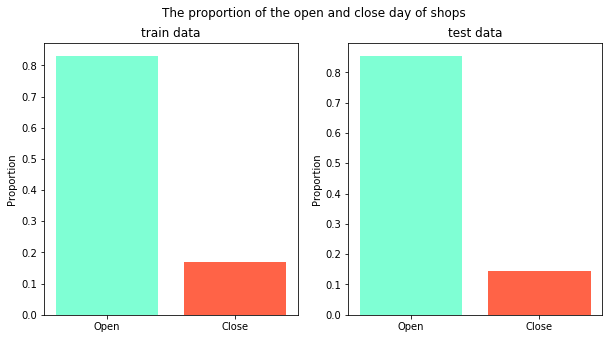

In [19]:
# The proportion of open and close in train and test data
# According to the graphs, they are quite similar.
# Most shops in the dataset are open

objects = ('Open', 'Close')
y = np.arange(len(objects))
x_train = [len(train.Open[train['Open'] == '1'])/len(train.Open), len(train.Open[train['Open'] == '0'])/len(train.Open)]
x_test = [len(test.Open[test['Open'] == '1'])/len(test.Open), len(test.Open[test['Open'] == '0'])/len(test.Open)]

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].bar(y, x_train, align='center', alpha=1, color=['aquamarine','tomato'])
ax[0].set_xticks(y)
ax[0].set_xticklabels(list(objects))
ax[0].set_ylabel('Proportion')
ax[0].set_title('train data')

ax[1].bar(y, x_test, align='center', alpha=1, color=['aquamarine','tomato'])
ax[1].set_xticks(y)
ax[1].set_xticklabels(list(objects))
ax[1].set_ylabel('Proportion')
ax[1].set_title('test data')

plt.suptitle('The proportion of the open and close day of shops')
plt.show()

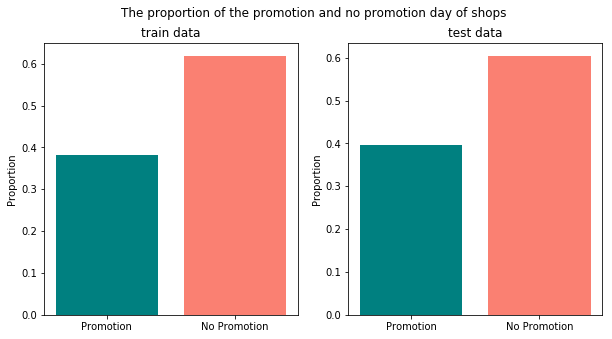

In [20]:
# The proportion of promotion and no promotion day in train and test data 
# Most data in the dataset do not have the promotion

objects = ('Promotion', 'No Promotion')
y = np.arange(len(objects))
x_train = [len(train.Promo[train['Promo'] == '1'])/len(train.Promo), len(train.Promo[train['Promo'] == '0'])/len(train.Promo)]
x_test = [len(test.Promo[test["Promo"] == '1'])/len(test.Promo), len(test.Promo[test["Promo"] == '0'])/len(test.Promo)]

colors = ['teal','salmon']

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].bar(y, x_train, align='center', alpha=1, color=colors)
ax[0].set_xticks(y)
ax[0].set_xticklabels(list(objects))
ax[0].set_ylabel('Proportion')
ax[0].set_title('train data')

ax[1].bar(y, x_test, align='center', alpha=1, color=colors)
ax[1].set_xticks(y)
ax[1].set_xticklabels(list(objects))
ax[1].set_ylabel('Proportion')
ax[1].set_title('test data')

plt.suptitle('The proportion of the promotion and no promotion day of shops')
plt.show()

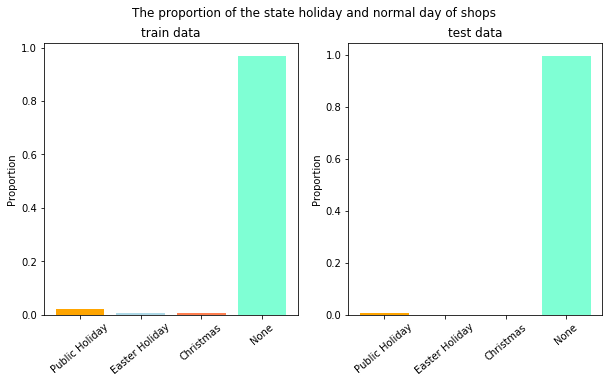

In [21]:
# The proportion of holiday and normal day in train and test data 
# Most day in the dataset is a normal day.


objects = ('Public Holiday', 'Easter Holiday', 'Christmas', 'None')
y = np.arange(len(objects))
x_train = [len(train.StateHoliday[train["StateHoliday"] == 'a'])/len(train.StateHoliday), 
           len(train.StateHoliday[train["StateHoliday"] == 'b'])/len(train.StateHoliday), 
           len(train.StateHoliday[train["StateHoliday"] == 'c'])/len(train.StateHoliday), 
           len(train.StateHoliday[train["StateHoliday"] == '0'])/len(train.StateHoliday)]
x_test = [len(test.StateHoliday[test["StateHoliday"] == 'a'])/len(test.StateHoliday), 
           len(test.StateHoliday[test["StateHoliday"] == 'b'])/len(test.StateHoliday), 
           len(test.StateHoliday[test["StateHoliday"] == 'c'])/len(test.StateHoliday), 
           len(test.StateHoliday[test["StateHoliday"] == '0'])/len(test.StateHoliday)]

colors = ['orange', 'lightblue', 'coral', 'aquamarine']

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].bar(y, x_train, align='center', alpha=1, color=colors)
ax[0].set_xticks(y)
ax[0].set_xticklabels(list(objects), rotation=40)
ax[0].set_ylabel('Proportion')
ax[0].set_title('train data')

ax[1].bar(y, x_test, align='center', alpha=1, color=colors)
ax[1].set_xticks(y)
ax[1].set_xticklabels(list(objects), rotation=40)
ax[1].set_ylabel('Proportion')
ax[1].set_title('test data')

plt.suptitle('The proportion of the state holiday and normal day of shops')
plt.show()

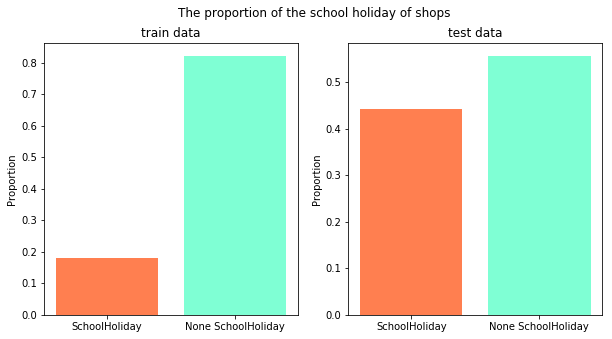

In [22]:
# The proportion of school and non-school holiday in train and test data 
# Most data in the dataset is not a school holiday.
# However, the proportion of the school holiday in test data is greater then train data.

objects = ('SchoolHoliday', 'None SchoolHoliday')
y = np.arange(len(objects))
x_train = [len(train.SchoolHoliday[train["SchoolHoliday"] == '1'])/len(train.SchoolHoliday), 
           len(train.SchoolHoliday[train["SchoolHoliday"] == '0'])/len(train.SchoolHoliday)]
x_test = [len(test.SchoolHoliday[test["SchoolHoliday"] == '1'])/len(test.SchoolHoliday),
           len(test.SchoolHoliday[test["SchoolHoliday"] == '0'])/len(test.SchoolHoliday)]

colors = ['coral','aquamarine']

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].bar(y, x_train, align='center', alpha=1, color=colors)
ax[0].set_xticks(y)
ax[0].set_xticklabels(list(objects))
ax[0].set_ylabel('Proportion')
ax[0].set_title('train data')

ax[1].bar(y, x_test, align='center', alpha=1, color=colors)
ax[1].set_xticks(y)
ax[1].set_xticklabels(list(objects))
ax[1].set_ylabel('Proportion')
ax[1].set_title('test data')

plt.suptitle('The proportion of the school holiday of shops')
plt.show()

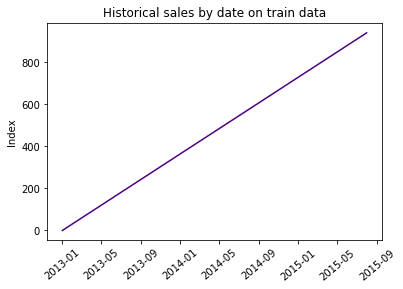

In [156]:
# In this dataset, most dataset is connected day by day.

dateRangeTrain = np.sort(train.Date.unique())

plt.plot(dateRangeTrain, range(0, len(dateRangeTrain)), color="indigo")
plt.title('Historical sales by date on train data')
plt.ylabel('Index')
plt.xticks(rotation=40)
plt.show()

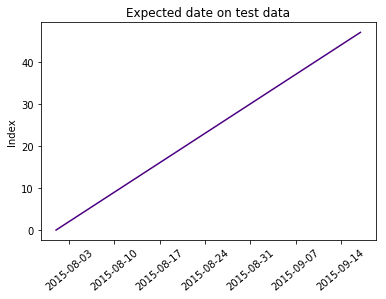

In [157]:
# We have to predict 48 days after the historical sales data in train data

dateRangeTest = np.sort(test.Date.unique())

plt.plot(dateRangeTest, range(0, len(dateRangeTest)), color="indigo")
plt.title('Expected date on test data')
plt.ylabel('Index')
plt.xticks(rotation=40)
plt.show()

## Histogram

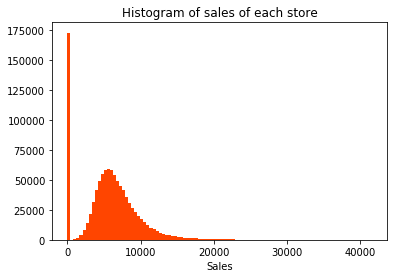

In [25]:
# Histogram of sales in train data
# According to histogram, there are too many zero sales on train data

plt.hist(train.Sales, 100, color="orangered")
plt.xlabel('Sales')
plt.title('Histogram of sales of each store')
plt.show()

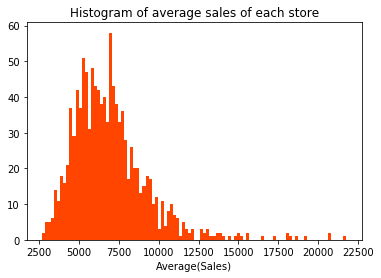

In [26]:
# Show the histogram of mean sales seperated by storeID.
# We have to filter out rows that contain zero sales 

plt.hist(train[train["Sales"] != 0].groupby(['Store']).Sales.mean(),100, color="orangered")
plt.xlabel('Average(Sales)')
plt.title('Histogram of average sales of each store')
plt.show()

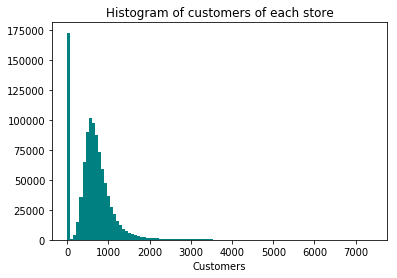

In [27]:
# Histogram of customers in train data
# According to histogram, there are zero customers on train data

plt.hist(train.Customers,100, color="teal")
plt.xlabel('Customers')
plt.title('Histogram of customers of each store')
plt.show()

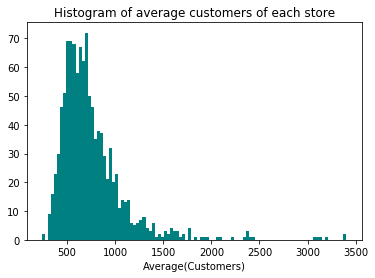

In [28]:
# Show the histogram of mean customers seperated by storeID.
# We have to filter out rows that contain zero sales 

plt.hist(train[train["Customers"] != 0].groupby(['Store']).Customers.mean(),100, color="teal")
plt.xlabel('Average(Customers)')
plt.title('Histogram of average customers of each store')
plt.show()

## Sales and other features

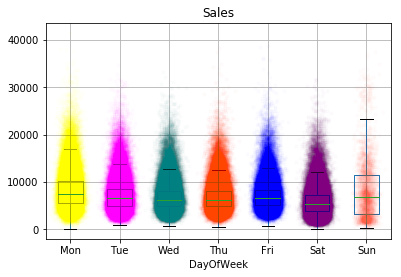

In [29]:
# Add boxplot to see a relation between sales and day of week
# May be, some shops might close on Sunday. 
# So, the density of sales on Sundey is not thick.

bp = train[train["Sales"] != 0].boxplot(column='Sales', by='DayOfWeek', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

for i in np.arange(1, 8): # 1-7
    y = train[train["Sales"] != 0].Sales[train.DayOfWeek==str(i)]
    x = np.random.normal(i, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color = colors[i-1])
    
plt.xticks(np.arange(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

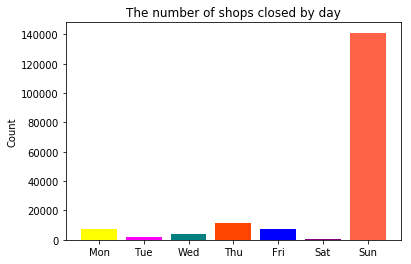

In [30]:
# Count the total number of closed shop by day of week.
# It related to the density of the above graph.

objects = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors=['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

fig, ax = plt.subplots()
for label, df in train[train["Open"] == '0'].groupby('DayOfWeek').DayOfWeek:
    plt.bar(label, df.count(), color=colors[int(label)-1])

plt.xticks(np.arange(1, 8), objects)
plt.ylabel('Count')
plt.title('The number of shops closed by day')
plt.show()


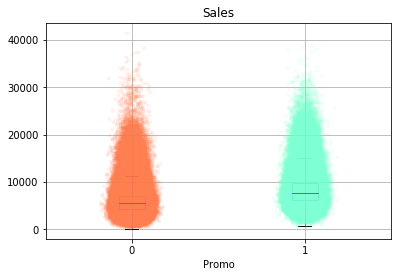

In [31]:
# Add boxplot to see a relation between sales and promotion
# When applying the promotion, it may increase the sales

bp = train[train["Sales"] != 0].boxplot(column='Sales', by='Promo', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Sales"] != 0].Sales[train.Promo==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.07, color= colors[i])


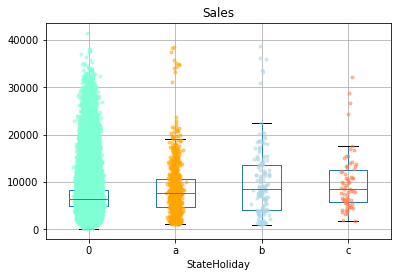

In [32]:
# Add boxplot to see a relation between sales and state holiday
# It seems that state holidays do not affect to the sales much

bp = train[train["Sales"] != 0].boxplot(column='Sales', by='StateHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors=['aquamarine', 'orange', 'lightblue', 'coral']

for i,j in enumerate(['0', 'a', 'b', 'c']):
    y = train[train["Sales"] != 0].Sales[train.StateHoliday==j]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5, color= colors[i])

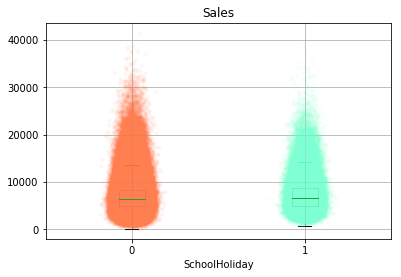

In [33]:
# Add boxplot to see a relation between sales and school holiday
# Without school holiday, the overall sales seem higher than on a school holiday

bp = train[train["Sales"] != 0].boxplot(column='Sales', by='SchoolHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Sales"] != 0].Sales[train.SchoolHoliday==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05, color= colors[i])

## Customers and other features

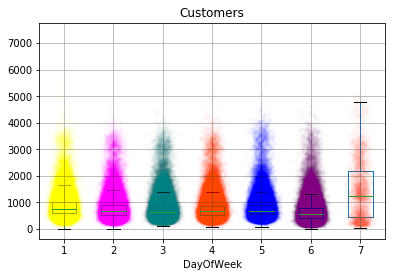

In [34]:
# Add boxplot to see a relation between customers and day of week
# May be shops might close on Sunday. 
# So, the density of customers on Sundey is not thick as same as on sales

bp = train[train["Customers"] != 0].boxplot(column='Customers', by='DayOfWeek', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['yellow','fuchsia', 'teal', 'orangered', 'blue', 'purple', 'tomato']

for i in np.arange(1,8): # 1-7
    y = train[train["Customers"] != 0].Customers[train.DayOfWeek==str(i)]
    x = np.random.normal(i, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color = colors[i-1])


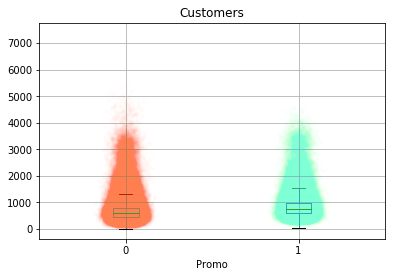

In [35]:
# Add boxplot to see a relation between customers and promotion
# When applying the promotion, it may not increase the customers

bp = train[train["Customers"] != 0].boxplot(column='Customers', by='Promo', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Customers"] != 0].Customers[train.Promo==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.01, color= colors[i])


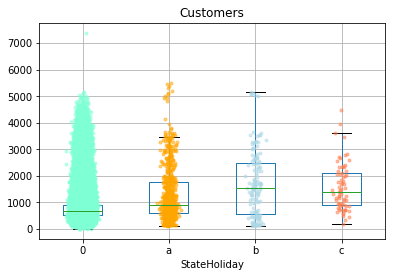

In [36]:
# Add boxplot to see a relation between customers and state holiday
# It seems that state holidays do not affect to the number of customers much

bp = train[train["Customers"] != 0].boxplot(column='Customers', by='StateHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors=['aquamarine', 'orange', 'lightblue', 'coral']

for i,j in enumerate(['0', 'a', 'b', 'c']):
    y = train[train["Customers"] != 0].Customers[train.StateHoliday==j]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.5, color= colors[i])

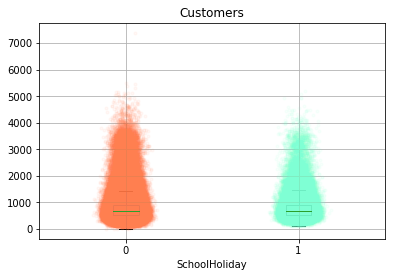

In [37]:
# Add boxplot to see a relation between customers and school holiday
# It's the same as sales

bp = train[train["Customers"] != 0].boxplot(column='Customers', by='SchoolHoliday', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = train[train["Customers"] != 0].Customers[train.SchoolHoliday==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, '.', alpha=0.05, color= colors[i])

## Sales and customers

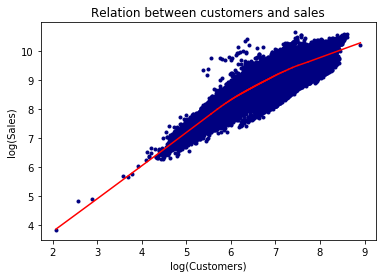

In [38]:
# Sales and Customers with regression line
# It is possible to assume that customers and sales have a positive relation

sale_and_customer = train[["Sales","Customers"]][(train["Sales"] != 0) & (train["Customers"] != 0)]

x = np.log(sale_and_customer.Customers)
y = np.log(sale_and_customer.Sales)

plt.plot(x, y, '.', color='navy')

filtered = lowess(y, x, is_sorted=False, frac=0.2, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')
plt.xlabel('log(Customers)')
plt.ylabel('log(Sales)')
plt.title('Relation between customers and sales')
plt.show()

## Miscellaneous

In [39]:
# There are just 2 rows that have customers but do not have sales.
train[["Store", "Sales","Customers"]][(train["Sales"] == 0) & (train["Customers"] != 0)]

,Store,Sales,Customers
478649,1100,0,3
889932,948,0,5


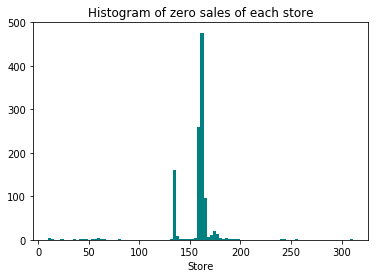

In [40]:
# Stores that have zero sales in each day
# The stores have different amounts of zero sales
# So, we will explore in the next step

storeWithZeroSales = train[(train["Sales"] == 0)].groupby(['Store']).Sales.size().sort_values(ascending=False)
plt.title('Histogram of zero sales of each store')
plt.hist(storeWithZeroSales,100, color="teal")
plt.xlabel("Store")
plt.show()

In [41]:
# Store 103 have the most zero sales among all stores
# The second zero sales is store 708

storeWithZeroSales.head()

Store
103    311
708    255
349    242
972    240
674    197
Name: Sales, dtype: int64

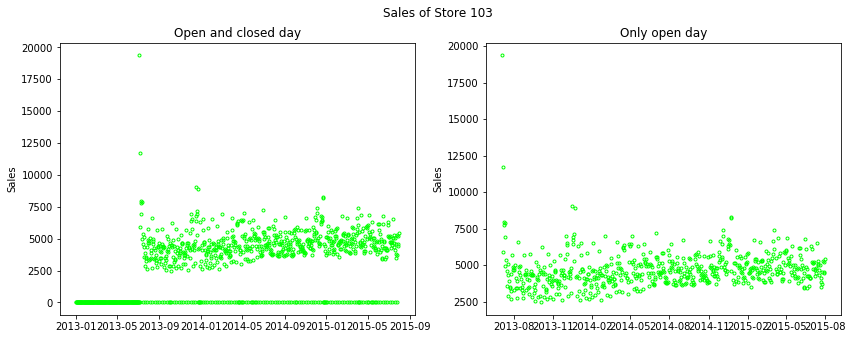

In [42]:
# The sales of store 103 
# This store opened after the first date of record this dataset
# The first period that new store openning have a high spike on sales

salesByDayStore103 = train[["Sales","Date"]][train["Store"] == 103]
salesByDayStore103WithOpen = train[["Sales","Date"]][(train["Store"] == 103) & (train["Open"] == '1')]

f, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(salesByDayStore103.Date, salesByDayStore103.Sales,'o',markerfacecolor='none', markersize=3, color='lime')
ax[0].set_ylabel('Sales')
ax[0].set_title('Open and closed day')

ax[1].plot(salesByDayStore103WithOpen.Date, salesByDayStore103WithOpen.Sales,'o',
           markerfacecolor='none', markersize=3, color='lime')
ax[1].set_ylabel('Sales')
ax[1].set_title('Only open day')

plt.suptitle('Sales of Store 103')
plt.show()

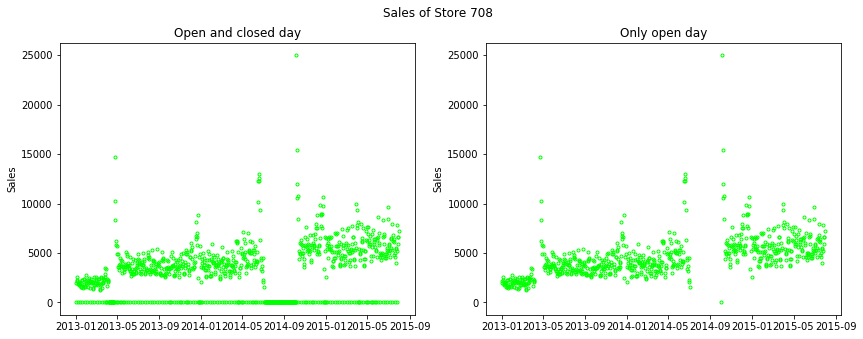

In [43]:
# The sales of store 708 
# When stores open after closing for a while, there is a high spike on sales
# It is the same case as closing. When the stores will close for a while, the last day will have a high spike on sales.

salesByDayStore708 = train[["Sales","Date"]][train["Store"] == 708]
salesByDayStore708WithOpen = train[["Sales","Date"]][(train["Store"] == 708) & (train["Open"] == '1')]

f, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].plot(salesByDayStore708.Date, salesByDayStore708.Sales,'ro',markerfacecolor='none', markersize=3, color='lime')
ax[0].set_ylabel('Sales')
ax[0].set_title('Open and closed day')

ax[1].plot(salesByDayStore708WithOpen.Date, salesByDayStore708WithOpen.Sales,'o',
           markerfacecolor='none', markersize=3, color='lime')
ax[1].set_ylabel('Sales')
ax[1].set_title('Only open day')

plt.suptitle('Sales of Store 708')
plt.show()

In [44]:
# There are some shops that open twentyfour-seven

train[(train["Open"] == '1') & (train["DayOfWeek"] == '7') & (train["StateHoliday"] != '0')].groupby(["Store"]).Store.head()

1010872    353
1011467    948
Name: Store, dtype: int32

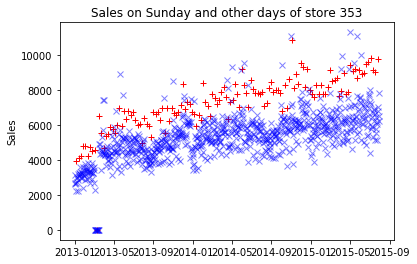

In [45]:
# The sales of store 353 
# The sales on Sunday is higher than other days.

# Only sales on Sunday
salesByDayOnSundayStore353 = train[["Sales","Date"]][(train["Store"] == 353) & (train["DayOfWeek"] == '7')]
plt.plot(salesByDayOnSundayStore353.Date, salesByDayOnSundayStore353.Sales, 'r+', alpha=1)

# Sales except Sunday
salesByDayNotSundayStore353 = train[["Sales","Date"]][(train["Store"] == 353) & (train["DayOfWeek"] != '7')]
plt.plot(salesByDayNotSundayStore353.Date, salesByDayNotSundayStore353.Sales, 'bx', alpha=0.5)
plt.ylabel('Sales')
plt.title('Sales on Sunday and other days of store 353')
plt.show()

# Store data

In [46]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.000000,1115,1115,1112.000000,761,761,1115,571,571,571
unique,nan,4,3,nan,12,23,2,24,7,3
top,nan,a,a,nan,9,2013,1,14,2011,"Jan,Apr,Jul,Oct"
freq,nan,602,593,nan,125,83,571,81,128,335
mean,558.000000,NaN,NaN,5404.901079,NaN,NaN,NaN,NaN,NaN,NaN
std,322.017080,NaN,NaN,7663.174720,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,279.500000,NaN,NaN,717.500000,NaN,NaN,NaN,NaN,NaN,NaN
50%,558.000000,NaN,NaN,2325.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,836.500000,NaN,NaN,6882.500000,NaN,NaN,NaN,NaN,NaN,NaN


## Find unique values and its null value

In [47]:
# Find null value of competition open month and year
monthNullAndYearNotNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(store["CompetitionOpenSinceMonth"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
monthNotNullAndYearNull = store[["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]][(~store["CompetitionOpenSinceMonth"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]

print('monthNullAndYearNotNull', len(monthNullAndYearNotNull))
print('monthNotNullAndYearNull', len(monthNotNullAndYearNull))

monthNullAndYearNotNull 0
monthNotNullAndYearNull 0


In [48]:
# Find null value of competition distance and open year
# There are some stores that have competition distance but do not have open year

distanceNullAndYearNotNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(store["CompetitionDistance"].isnull()) & (~store["CompetitionOpenSinceYear"].isnull())]
distanceNotNullAndYearNull = store[["CompetitionDistance", "CompetitionOpenSinceYear"]][(~store["CompetitionDistance"].isnull()) & (store["CompetitionOpenSinceYear"].isnull())]
print('distanceNullAndYearNotNull', len(distanceNullAndYearNotNull))
print('distanceNotNullAndYearNull', len(distanceNotNullAndYearNull))


distanceNullAndYearNotNull 0
distanceNotNullAndYearNull 351


In [49]:
# some of row have distance but doesn't have year and month
# we have to fix it later.

distanceNotNullAndYearNull.head()

,CompetitionDistance,CompetitionOpenSinceYear
11,1070.000000,NaN
12,310.000000,NaN
15,3270.000000,NaN
18,3240.000000,NaN
21,1040.000000,NaN


In [50]:
# Find null value of promotion week and year

promoWeekNullAndYearNotNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(store["Promo2SinceWeek"].isnull()) & (~store["Promo2SinceYear"].isnull())]
promoWeekNotNullAndYearNull = store[["Promo2SinceWeek", "Promo2SinceYear"]][(~store["Promo2SinceWeek"].isnull()) & (store["Promo2SinceYear"].isnull())]

print('promoWeekNullAndYearNotNull', len(promoWeekNullAndYearNotNull))
print('promoWeekNotNullAndYearNull', len(promoWeekNotNullAndYearNull))

promoWeekNullAndYearNotNull 0
promoWeekNotNullAndYearNull 0


In [51]:
# Find null value of promo2 and promo2SinceYear

promoUseAndYearNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == '1') & (store["Promo2SinceYear"].isnull())]
promoNotUseAndYearNotNull = store[["Promo2", "Promo2SinceYear"]][(store["Promo2"] == '0') & (~store["Promo2SinceYear"].isnull())]
print('promoUseAndYearNull', len(promoUseAndYearNull))
print('promoNotUseAndYearNotNull', len(promoNotUseAndYearNotNull))


promoUseAndYearNull 0
promoNotUseAndYearNotNull 0


In [52]:
# Find null value of promo2 and PromoInterval

promoUseAndIntervalNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == '1') & (store["PromoInterval"].isnull())]
promoNotUseAndIntervalNotNull = store[["Promo2", "PromoInterval"]][(store["Promo2"] == '0') & (~store["PromoInterval"].isnull())]
print('promoUseAndIntervalNull', len(promoUseAndIntervalNull))
print('promoNotUseAndIntervalNotNull', len(promoNotUseAndIntervalNotNull))


promoUseAndIntervalNull 0
promoNotUseAndIntervalNotNull 0


## Proportion of interesting features

matplotlib.cbook.silent_list

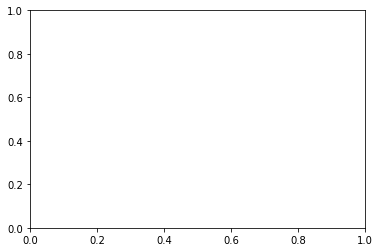

In [189]:
type(plt.xticks()[1])

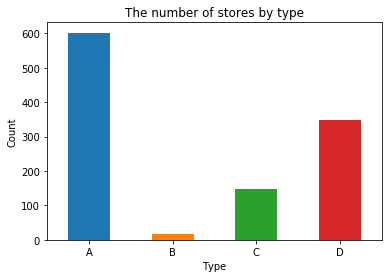

In [191]:
# Show store type of each store
# About half of all store are type A.
# Type B is the smallest number from all stores.

ax = store.StoreType.value_counts(dropna=False).sort_index().plot.bar(rot=0)
plt.ylabel('Count')
plt.xlabel('Type')
plt.xticks(plt.xticks()[0], ['A', 'B', 'C', 'D'])
plt.title('The number of stores by type')
plt.show()

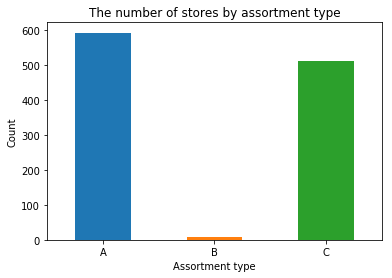

In [192]:
# Show Assortment of each store
# Most assortment types of stores are A and C.

store.Assortment.value_counts(dropna=False).sort_index().plot.bar(rot=0)
plt.ylabel('Count')
plt.xlabel('Assortment type')
plt.xticks(plt.xticks()[0], ['A', 'B', 'C'])
plt.title('The number of stores by assortment type')
plt.show()

In [158]:
# Crosstab of assortment and store type
# The proportion of assortment and store type.
# Store A with Assortment A is the most popular, 381 stores.
# The number of store A and D with Assortment C is quite similar, about 220 stores.

pd.crosstab(store.StoreType,store.Assortment,dropna=False)

Assortment,a,b,c
StoreType,,,
a,381,0,221
b,7,9,1
c,77,0,71
d,128,0,220


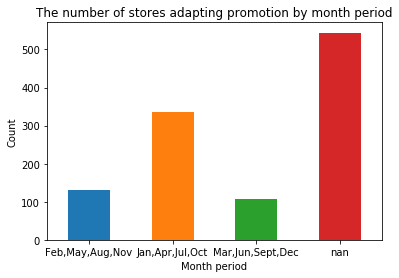

In [159]:
# Promotion Interval of each store
# About half of all store does not have month promotions
# The popular months for the promotion are Jan, Apr, Jul, Oct.

store.PromoInterval.value_counts(dropna=False).sort_index().plot.bar(rot=0)
plt.ylabel('Count')
plt.xlabel('Month period')
plt.title('The number of stores adapting promotion by month period')
plt.show()

## Histogram

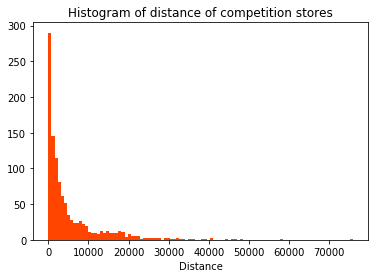

In [57]:
# histogram of distance of competition stores in store data
# According to histogram, some competition stores are far away
# Most distance of competition stores are less than 5000m.

plt.hist(store.CompetitionDistance.dropna(), 100, color="orangered")
plt.xlabel('Distance')
plt.title('Histogram of distance of competition stores')
plt.show()

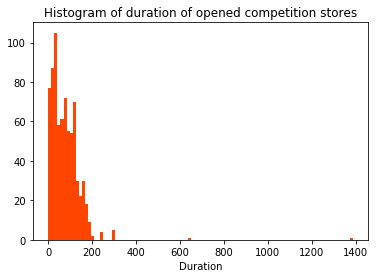

In [58]:
# concat year and month then find the newest competition store date
# We have to find how long that each competition store open
# Most competition stores have openned less than 200 months, about 16 years.

competitionOpenYearMonth = store.CompetitionOpenSinceYear.str.cat(store.CompetitionOpenSinceMonth)
competitionOpenYearMonth = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore').dt.to_period('M')
newestCompetitionYearMonth = competitionOpenYearMonth.sort_values(ascending = False).iloc[0]


openSinceInMonth = newestCompetitionYearMonth - competitionOpenYearMonth
openSinceInMonth = openSinceInMonth.astype('int32')
plt.hist(openSinceInMonth,100, color="orangered")
plt.xlabel('Duration')
plt.title('Histogram of duration of opened competition stores')
plt.show()

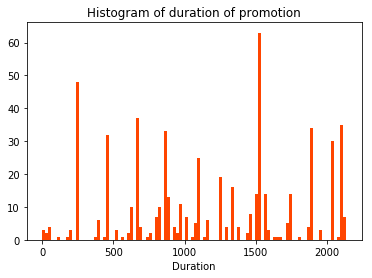

In [59]:
# The oldest year for applying promotion2 is 2009, about 2000 days ago.

# First day of the promotion will start on Monday.
promoStartYearMonth = store[(store["Promo2"] == '1')][['Promo2SinceYear','Promo2SinceWeek']]
promoStartYearMonth = pd.to_datetime(promoStartYearMonth.Promo2SinceWeek.astype(str)+
                          promoStartYearMonth.Promo2SinceYear.astype(str).add('-1') ,format='%W%Y-%w')
newestPromoStartYearMonth = pd.to_datetime(promoStartYearMonth.sort_values(ascending = False).iloc[0])

# We have to find how long that each store has a promotion
promoSinceInMonth = newestPromoStartYearMonth - promoStartYearMonth
promoSinceInMonth = promoSinceInMonth.astype('timedelta64[D]')
plt.hist(promoSinceInMonth,100, color="orangered")
plt.xlabel('Duration')
plt.title('Histogram of duration of promotion')
plt.show()

# Sales and customers with other features in store data

In [60]:
# We have to merge 2 dataset together.

saleAndStore = pd.merge(train, store, on='Store')
saleAndStore = saleAndStore.fillna({'PromoInterval': 'None'})

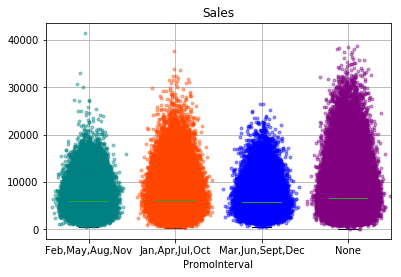

In [61]:
# Sales and Promotion Interval by month
# When applying the promotion by month, it might not increase sales. 

bp = saleAndStore[saleAndStore["Sales"] != 0].boxplot(column='Sales', by='PromoInterval', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

PromoInterval=['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', 'None']
colors = ['teal', 'orangered', 'blue', 'purple']

for i,j in enumerate(PromoInterval):
    y = saleAndStore[saleAndStore["Sales"] != 0].Sales[saleAndStore.PromoInterval==j]
    x = np.random.normal(i+1, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.4, color= colors[i])

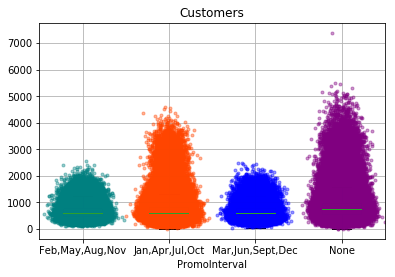

In [62]:
# Customers and Promotion Interval by month
# When applying the promotion by month, it might not increase customers. 

bp = saleAndStore[saleAndStore["Customers"] != 0].boxplot(column='Customers', by='PromoInterval', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

PromoInterval=['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', 'None']
colors = ['teal', 'orangered', 'blue', 'purple']

for i,j in enumerate(PromoInterval):
    y = saleAndStore[saleAndStore["Customers"] != 0].Customers[saleAndStore.PromoInterval==j]
    x = np.random.normal(i+1, 0.1, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.4, color= colors[i])

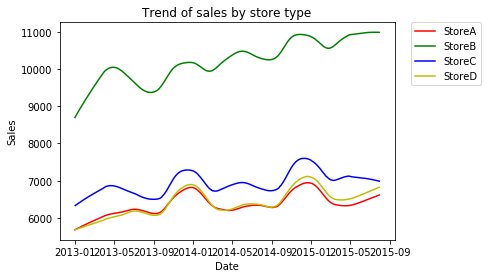

In [63]:
# Sales by store types
# Store B seems to have more growth in sales
# Store A, C and D have slight growth in sales.

saleDateByStore = saleAndStore[(saleAndStore["Sales"] != 0)][["StoreType","Date","Sales"]]
saleDateByStore = saleDateByStore.groupby(['StoreType','Date']).Sales.mean().reset_index()
saleDateByStoreA = saleDateByStore[saleDateByStore["StoreType"] == 'a'][['Date','Sales']]
saleDateByStoreB = saleDateByStore[saleDateByStore["StoreType"] == 'b'][['Date','Sales']]
saleDateByStoreC = saleDateByStore[saleDateByStore["StoreType"] == 'c'][['Date','Sales']]
saleDateByStoreD = saleDateByStore[saleDateByStore["StoreType"] == 'd'][['Date','Sales']]

filteredA = lowess(saleDateByStoreA.Sales, saleDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByStoreB.Sales, saleDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByStoreC.Sales, saleDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(saleDateByStoreD.Sales, saleDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='StoreA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='StoreB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='StoreC')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y', label='StoreD')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trend of sales by store type')
plt.show()

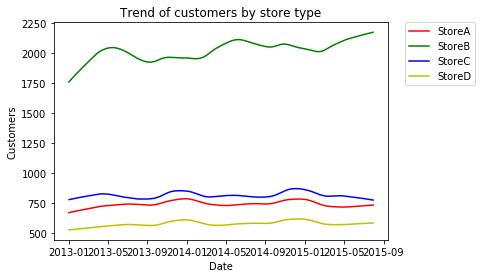

In [64]:
# Customers by store types
# Store B seems to have more growth in customers
# The customers of store A, C and D maintain the same level

customerDateByStore = saleAndStore[(saleAndStore["Customers"] != 0)][["StoreType","Date","Customers"]]
customerDateByStore = customerDateByStore.groupby(['StoreType','Date']).Customers.mean().reset_index()
customerDateByStoreA = customerDateByStore[customerDateByStore["StoreType"] == 'a'][['Date','Customers']]
customerDateByStoreB = customerDateByStore[customerDateByStore["StoreType"] == 'b'][['Date','Customers']]
customerDateByStoreC = customerDateByStore[customerDateByStore["StoreType"] == 'c'][['Date','Customers']]
customerDateByStoreD = customerDateByStore[customerDateByStore["StoreType"] == 'd'][['Date','Customers']]

filteredA = lowess(customerDateByStoreA.Customers, customerDateByStoreA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(customerDateByStoreB.Customers, customerDateByStoreB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(customerDateByStoreC.Customers, customerDateByStoreC.Date, is_sorted=False, frac=0.2, it=0)
filteredD = lowess(customerDateByStoreD.Customers, customerDateByStoreD.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='StoreA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='StoreB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='StoreC')
plt.plot(pd.to_datetime(filteredD[:,0]), filteredD[:,1], 'y', label='StoreD')

plt.ylabel('Customers')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trend of customers by store type')
plt.show()

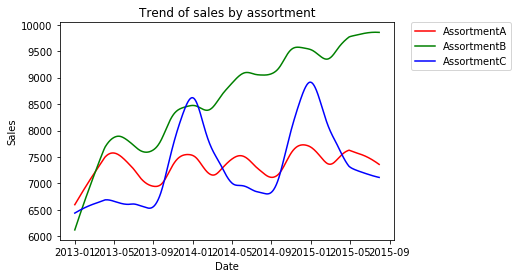

In [65]:
# Sales by store types
# Assortment B has significant growth in sales
# Assortment A has slight growth in sales
# Assortment C has wild fluctuation in sales 

saleDateByAssortment = saleAndStore[(saleAndStore["Sales"] != 0)][["Assortment","Date","Sales"]]
saleDateByAssortment = saleDateByAssortment.groupby(['Assortment','Date']).Sales.mean().reset_index()
saleDateByAssortmentA = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'a'][['Date','Sales']]
saleDateByAssortmentB = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'b'][['Date','Sales']]
saleDateByAssortmentC = saleDateByAssortment[saleDateByAssortment["Assortment"] == 'c'][['Date','Sales']]

filteredA = lowess(saleDateByAssortmentA.Sales, saleDateByAssortmentA.Date, is_sorted=False, frac=0.2, it=0)
filteredB = lowess(saleDateByAssortmentB.Sales, saleDateByAssortmentB.Date, is_sorted=False, frac=0.2, it=0)
filteredC = lowess(saleDateByAssortmentC.Sales, saleDateByAssortmentC.Date, is_sorted=False, frac=0.2, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='AssortmentA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='AssortmentB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='AssortmentC')

plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trend of sales by assortment')
plt.show()

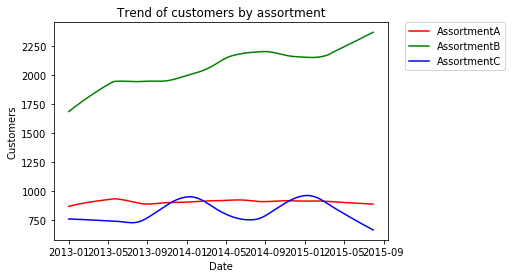

In [66]:
# Customers by store types
# Assortment B has significant growth in customers
# Assortment A has the same level of customers
# Customer level in assortment C has slightly decreased.

customerDateByAssortment = saleAndStore[(saleAndStore["Customers"] != 0)][["Assortment","Date","Customers"]]
customerDateByAssortment = customerDateByAssortment.groupby(['Assortment','Date']).Customers.mean().reset_index()
customerDateByAssortmentA = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'a'][['Date','Customers']]
customerDateByAssortmentB = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'b'][['Date','Customers']]
customerDateByAssortmentC = customerDateByAssortment[customerDateByAssortment["Assortment"] == 'c'][['Date','Customers']]

filteredA = lowess(customerDateByAssortmentA.Customers, customerDateByAssortmentA.Date, is_sorted=False, frac=0.3, it=0)
filteredB = lowess(customerDateByAssortmentB.Customers, customerDateByAssortmentB.Date, is_sorted=False, frac=0.3, it=0)
filteredC = lowess(customerDateByAssortmentC.Customers, customerDateByAssortmentC.Date, is_sorted=False, frac=0.3, it=0)

plt.plot(pd.to_datetime(filteredA[:,0]), filteredA[:,1], 'r', label='AssortmentA')
plt.plot(pd.to_datetime(filteredB[:,0]), filteredB[:,1], 'g', label='AssortmentB')
plt.plot(pd.to_datetime(filteredC[:,0]), filteredC[:,1], 'b', label='AssortmentC')

plt.ylabel('Customers')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Trend of customers by assortment')
plt.show()

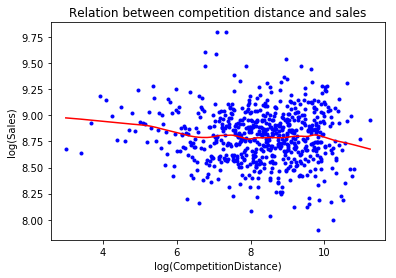

In [67]:
# Sales and distance
# According to the trend, sales and competition distance has negative relation

sale_and_distance = saleAndStore[["Sales","CompetitionDistance"]][(saleAndStore["Sales"] != 0) & (~saleAndStore["CompetitionDistance"].isnull())].groupby(['CompetitionDistance']).Sales.mean().reset_index()

x = np.log(sale_and_distance.CompetitionDistance)
y = np.log(sale_and_distance.Sales)

plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.3, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

plt.xlabel('log(CompetitionDistance)')
plt.ylabel('log(Sales)')
plt.title('Relation between competition distance and sales')
plt.show()

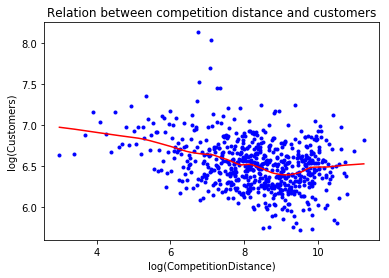

In [68]:
# Customers and distance
# According to the trend, customers and competition distance has negative relation

customer_and_distance = saleAndStore[["Customers","CompetitionDistance"]][(saleAndStore["Customers"] != 0) & (~saleAndStore["CompetitionDistance"].isnull())].groupby(['CompetitionDistance']).Customers.mean().reset_index()

x = np.log(customer_and_distance.CompetitionDistance)
y = np.log(customer_and_distance.Customers)

plt.plot(x, y, '.b')

filtered = lowess(y, x, is_sorted=False, frac=0.3, it=0)

plt.plot(filtered[:,0], filtered[:,1], 'r')

plt.xlabel('log(CompetitionDistance)')
plt.ylabel('log(Customers)')
plt.title('Relation between competition distance and customers')
plt.show()

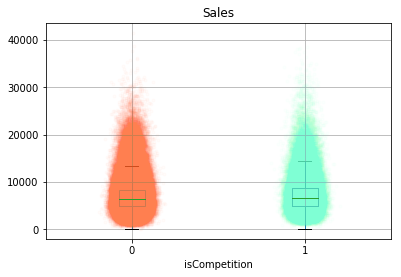

In [69]:
# If stores have competitions, sales might slightly decrease

SalesAndCompetition = saleAndStore[['Sales','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
SalesAndCompetition = SalesAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
SalesAndCompetition['isCompetition'] = np.where((SalesAndCompetition.Date.dt.year >= SalesAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (SalesAndCompetition.Date.dt.month >= SalesAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')

bp = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].boxplot(column='Sales', by='isCompetition', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = SalesAndCompetition[SalesAndCompetition["Sales"] != 0].Sales[SalesAndCompetition.isCompetition==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.02, color= colors[i])


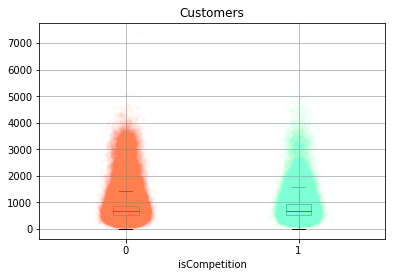

In [70]:
# If stores have competitions, customers might slightly decrease

CustomersAndCompetition = saleAndStore[['Customers','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']]
CustomersAndCompetition = CustomersAndCompetition.fillna({'CompetitionOpenSinceYear': '9999', 'CompetitionOpenSinceMonth': '99'})
CustomersAndCompetition['isCompetition'] = np.where((CustomersAndCompetition.Date.dt.year >= CustomersAndCompetition['CompetitionOpenSinceYear'].astype(int)) &
                                                (CustomersAndCompetition.Date.dt.month >= CustomersAndCompetition['CompetitionOpenSinceMonth'].astype(int)), '1', '0')

bp = CustomersAndCompetition[CustomersAndCompetition["Customers"] != 0].boxplot(column='Customers', by='isCompetition', grid=True, showfliers=False)
fig = bp.get_figure()
fig.suptitle('')

colors = ['coral', 'aquamarine']

for i in [0, 1]:
    y = CustomersAndCompetition[CustomersAndCompetition["Customers"] != 0].Customers[CustomersAndCompetition.isCompetition==str(i)]
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.02, color= colors[i])


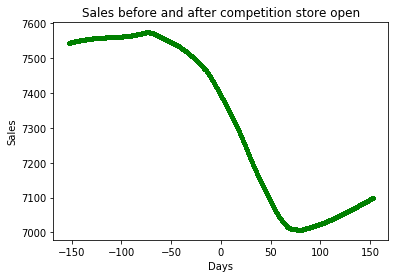

In [71]:
# Trend of average sales of store before and after competition has openned nearby.
# After competition has opened nearby, sales is significant dropped.

saleAndCompetitionBeforeAfter = saleAndStore[~saleAndStore['CompetitionOpenSinceYear'].isnull()][['Store','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales']]

competitionOpenYearMonth = saleAndCompetitionBeforeAfter.CompetitionOpenSinceYear.str.cat(saleAndCompetitionBeforeAfter.CompetitionOpenSinceMonth)
saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore')
saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=-5)
saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'] = saleAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=5)

result = saleAndCompetitionBeforeAfter[['Store', 'Date', 'Sales','competitionOpenYearMonth']][((saleAndCompetitionBeforeAfter['Date'] >= saleAndCompetitionBeforeAfter['competitionOpenYearMonthBefore']) & (saleAndCompetitionBeforeAfter['Date'] <= saleAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'])) & (saleAndCompetitionBeforeAfter['Sales']!=0)]

filtered = lowess(result.Sales, (result.Date - result.competitionOpenYearMonth).dt.days, is_sorted=False, frac=0.5, it=0)

plt.plot(filtered[:,0], filtered[:,1], '.g')

plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Sales before and after competition store open')
plt.show()



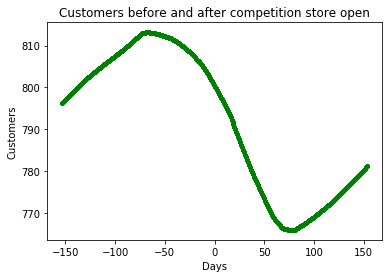

In [72]:
# Trend of average customers of store before and after competition has openned nearby.
# After competition has opened nearby, customers is significant dropped for a while and tend to increase.

customersAndCompetitionBeforeAfter = saleAndStore[~saleAndStore['CompetitionOpenSinceYear'].isnull()][['Store','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Customers']]

competitionOpenYearMonth = customersAndCompetitionBeforeAfter.CompetitionOpenSinceYear.str.cat(customersAndCompetitionBeforeAfter.CompetitionOpenSinceMonth)
customersAndCompetitionBeforeAfter['competitionOpenYearMonth'] = pd.to_datetime(competitionOpenYearMonth.dropna(), format='%Y%m', errors='ignore')
customersAndCompetitionBeforeAfter['competitionOpenYearMonthBefore'] = customersAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=-5)
customersAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'] = customersAndCompetitionBeforeAfter['competitionOpenYearMonth'] + pd.DateOffset(months=5)

result = customersAndCompetitionBeforeAfter[['Store', 'Date', 'Customers','competitionOpenYearMonth']][((customersAndCompetitionBeforeAfter['Date'] >= customersAndCompetitionBeforeAfter['competitionOpenYearMonthBefore']) & (customersAndCompetitionBeforeAfter['Date'] <= customersAndCompetitionBeforeAfter['competitionOpenYearMonthAfter'])) & (customersAndCompetitionBeforeAfter['Customers']!=0)]

filtered = lowess(result.Customers, (result.Date - result.competitionOpenYearMonth).dt.days, is_sorted=False, frac=0.5, it=0)

plt.plot(filtered[:,0], filtered[:,1], '.g')

plt.xlabel('Days')
plt.ylabel('Customers')
plt.title('Customers before and after competition store open')
plt.show()


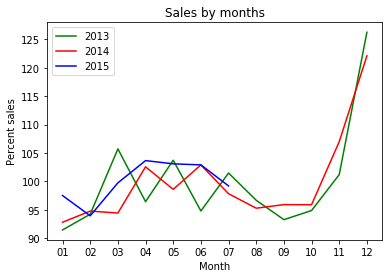

In [73]:
# It could be said that sales in 2013 and 2014 skyrocketed in November and December
# For 2015, the sales might follow the previous trend in 2013 and 2014.

saleAndDate = saleAndStore[['Sales','Date']][saleAndStore['Sales'] != 0]
saleByMonth2013 = saleAndDate[saleAndDate['Date'].dt.year == 2013].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2014 = saleAndDate[saleAndDate['Date'].dt.year == 2014].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)
saleByMonth2015 = saleAndDate[saleAndDate['Date'].dt.year == 2015].groupby(saleAndDate['Date'].dt.strftime('%m'))['Sales'].mean().sort_index(level="Date", ascending=True)

plt.plot(saleByMonth2013.keys(), (saleByMonth2013 / np.mean(saleByMonth2013)) * 100, '-g', label = '2013')
plt.plot(saleByMonth2014.keys(), (saleByMonth2014 / np.mean(saleByMonth2014)) * 100, '-r', label = '2014')
plt.plot(saleByMonth2015.keys(), (saleByMonth2015 / np.mean(saleByMonth2015)) * 100, '-b', label = '2015')

plt.xlabel('Month')
plt.ylabel('Percent sales')
plt.title('Sales by months')
plt.legend()
plt.show()


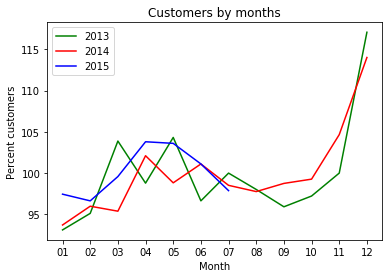

In [74]:
# It cound be said that customers in 2013 and 2014 skyrockets in November and December
# For 2015, the customers might follow the previous trend in 2013 and 2014.

customerAndDate = saleAndStore[['Customers','Date']][saleAndStore['Customers'] != 0]
customerByMonth2013 = customerAndDate[customerAndDate['Date'].dt.year == 2013].groupby(customerAndDate['Date'].dt.strftime('%m'))['Customers'].mean().sort_index(level="Date", ascending=True)
customerByMonth2014 = customerAndDate[customerAndDate['Date'].dt.year == 2014].groupby(customerAndDate['Date'].dt.strftime('%m'))['Customers'].mean().sort_index(level="Date", ascending=True)
customerByMonth2015 = customerAndDate[customerAndDate['Date'].dt.year == 2015].groupby(customerAndDate['Date'].dt.strftime('%m'))['Customers'].mean().sort_index(level="Date", ascending=True)

plt.plot(customerByMonth2013.keys(), (customerByMonth2013 / np.mean(customerByMonth2013)) * 100, '-g', label = '2013')
plt.plot(customerByMonth2014.keys(), (customerByMonth2014 / np.mean(customerByMonth2014)) * 100, '-r', label = '2014')
plt.plot(customerByMonth2015.keys(), (customerByMonth2015 / np.mean(customerByMonth2015)) * 100, '-b', label = '2015')

plt.xlabel('Month')
plt.ylabel('Percent customers')
plt.title('Customers by months')
plt.legend()
plt.show()
